In [91]:
import sqlite3
# pair_name = 'FEI_USDC'
def create_table(pair_name):
    query_0 = f"""
    Drop table if exists uniswap_swap_{pair_name};
    """
    con =sqlite3.connect("uniswap.sqlite")
    con.execute(query_0)
    con.commit()
    query = f"""
    Create Table uniswap_swap_{pair_name}
    (
        pair_name varchar(20),
        block_timestamp datetime,
        actual_price_a2b    REAL,
        actual_price_b2a    REAL,
        amount0In           REAL,
        amount0Out          REAL,
        amount1In           REAL,
        amount1Out          REAL,
        transaction_hash VARCHAR(255),
        
        block_number    INTEGER,
        log_index       INTEGER,
        contract_address    VARCHAR(255),
        sender_addr              VARCHAR(255), 
        to_addr                  VARCHAR(255)
        
    );

    """
    con =sqlite3.connect("uniswap.sqlite")
    con.execute(query)
    con.commit()

In [115]:
import pandas as pd
import numpy as np
def process_data(file_name, pair_name, coin_a_digit=18, coin_b_digit=18):
    dt_index = pd.Index(["pair_name","block_timestamp","actual_price_a2b","actual_price_b2a","amount0In","amount0Out","amount1In","amount1Out","transaction_hash","block_number","log_index","contract_address","sender_addr","to_addr", "sender","to"])
    dt = pd.read_csv(file_name)
    dt = dt.reindex(dt_index,axis=1)
    dt.index.name = "id"
    dt['pair_name'] = pair_name
    dt['sender_addr'] = dt['sender']
    dt['to_addr'] = dt['to']
    del dt['to']
    del dt['sender']
    dt['block_timestamp'] = pd.to_datetime(dt['block_timestamp'], utc=True, format="%Y-%m-%d %H:%M:%S UTC")
    dt['amount0In'] = dt.amount0In.astype(np.float64) / pow(10, coin_a_digit)
    dt['amount0Out'] = dt.amount0Out.astype(np.float64) / pow(10, coin_a_digit)
    dt['amount1In'] = dt.amount1In.astype(np.float64) / pow(10, coin_b_digit)
    dt['amount1Out'] = dt.amount1Out.astype(np.float64) / pow(10, coin_b_digit)
    dt['actual_price_a2b'] = dt.amount1Out / dt.amount0In
    dt['actual_price_b2a'] = dt.amount0Out / dt.amount1In
    dt['actual_price_a2b'].fillna(-1, inplace=True)
    dt['actual_price_b2a'].fillna(-1, inplace=True)
    # print(np.where(dt['actual_price_a2b'] == -1, 1 / dt['actual_price_b2a'], dt['actual_price_a2b']))
    dt['actual_price_a2b'] = np.where(dt['actual_price_a2b'] == -1, 1 / dt['actual_price_b2a'], dt['actual_price_a2b'])
    dt['actual_price_b2a'] = np.where(dt['actual_price_b2a'] == -1, 1 / dt['actual_price_a2b'], dt['actual_price_b2a'])
    dt = dt.sort_values(by='block_timestamp',ascending=False)
    return dt



In [116]:
import sqlite3
pair_name = "USDC_ETH"
create_table(pair_name)
df = process_data( r'C:\Users\qli32\Downloads\USDC_ETH.csv',pair_name,6,18)
con =sqlite3.connect("uniswap.sqlite")

df.to_sql(f'uniswap_swap_{pair_name}', con=con, if_exists='replace')

In [113]:
df = df.set_index('block_timestamp')

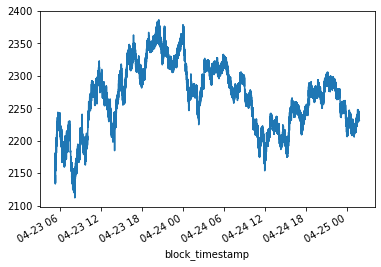

In [114]:
df.actual_price_b2a.plot()

In [121]:
pair_name = ['USDC_ETH',"FEI_USDC","FEI_ETH"]
digits = [(6,18),(18,6),(18,18)]
for p,(i,j) in zip(pair_name,digits):
    print(p, i, j)
    print("---------")
    
    # process_data(file,p, i, j)

USDC_ETH 6 18
---------
FEI_USDC 18 6
---------
FEI_ETH 18 18
---------


In [161]:
import sqlite3
conn = sqlite3.connect('uniswap.sqlite')

pair_names = ['FEI_ETH',"FEI_USDC",'USDC_ETH']
df = [0]*3
for i, pair_name in enumerate(pair_names):
    # print(i,pair_name)
    df[i] = pd.read_sql(f"select * from uniswap_swap_{pair_name}",conn)
    df[i] = df[i].set_index(['block_timestamp'])
    df[i] = df[i].sort_values(by=['block_number','block_number'], ascending=False)
    df[i] = df[i].sort_index(ascending= False)
df[2]

,id,pair_name,actual_price_a2b,actual_price_b2a,amount0In,amount0Out,amount1In,amount1Out,transaction_hash,block_number,log_index,contract_address,sender_addr,to_addr
block_timestamp,,,,,,,,,,,,,,
2021-04-25 01:44:44+00:00,0,USDC_ETH,0.000448,2231.016717,0.000000,2210.588000,0.990843,0.000000,0x91956a9e3be88f31be61458881b86fe836cc1a780a20...,12306517,25,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x36314738fce9aca7944d06d18a5fafc7925f26ff
2021-04-25 01:44:12+00:00,1,USDC_ETH,0.000448,2231.072872,0.000000,2268.329173,1.016699,0.000000,0x3d423c277494b62b1ed4965e998a61fc10d6206c90b8...,12306515,233,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x20a73256f10e739c550e31b914ba61fce99594cb
2021-04-25 01:43:15+00:00,2,USDC_ETH,0.000448,2231.119660,0.000000,1464.765992,0.656516,0.000000,0x2f4b78fa21291db15d16ffea04c1f8177d8f1ae692be...,12306511,186,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xe87a10d5b212d169ccbc9a50cf5e23dd3da27cb6
2021-04-25 01:42:58+00:00,3,USDC_ETH,0.000446,2244.544527,3238.152360,0.000000,0.000000,1.442677,0x88a25b032695972299f459f861c4af02db738031f8f8...,12306509,14,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x06441d79d21ff7ab135e7a4052025834a43a6fe3
2021-04-25 01:42:53+00:00,4,USDC_ETH,0.000446,2244.487989,1260.810544,0.000000,0.000000,0.561736,0xfbff65a1dc953b3c59e3887e83cb9dc0de5b2e4018c8...,12306508,191,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x3d2c5514344834b35df1587657caf22df74367ae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23 05:15:29+00:00,15995,USDC_ETH,0.000461,2167.638139,0.000000,17309.444925,7.985394,0.000000,0x41fa7c1ff6b41e915f0b06e74228301863cb10facd17...,12294509,180,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x05308684a12889ae50b76de3c1dcda26b15fd8bc
2021-04-23 05:15:19+00:00,15996,USDC_ETH,0.000459,2180.790709,3486.759090,0.000000,0.000000,1.598851,0x5babe4342b7f5de448f577723a0b2ee2ab0c5adf4ba4...,12294508,52,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,0xdfee68a9adb981cd08699891a11cabe10f25ec44
2021-04-23 05:15:11+00:00,15997,USDC_ETH,0.000459,2180.666050,1475.267784,0.000000,0.000000,0.676522,0x16f59744ee851a5459ae1cddc588d80846b03a70f2fa...,12294507,202,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xcd6bcca48069f8588780dfa274960f15685aee0e


In [176]:
i = df[2].index
# print(i.value_counts())
# df[1].reindex(i).isnull().sum()
tmp = df[2].loc['2021-04-23 08:41:26+00:00'].sort_values(by='log_index')
tmp.index
# spread = df[2].actual_price_b2a.sub(df[1].actual_price_b2a.mul(df[0].actual_price_a2b, 
# spread

Index(['2021-04-23 08:41:26+00:00', '2021-04-23 08:41:26+00:00',
       '2021-04-23 08:41:26+00:00', '2021-04-23 08:41:26+00:00',
       '2021-04-23 08:41:26+00:00', '2021-04-23 08:41:26+00:00',
       '2021-04-23 08:41:26+00:00', '2021-04-23 08:41:26+00:00',
       '2021-04-23 08:41:26+00:00', '2021-04-23 08:41:26+00:00',
       '2021-04-23 08:41:26+00:00', '2021-04-23 08:41:26+00:00',
       '2021-04-23 08:41:26+00:00', '2021-04-23 08:41:26+00:00'],
      dtype='object', name='block_timestamp')